In [1]:
import copy
import datetime
import math
from multiprocessing.pool import Pool # only needed on UNIX systems
import os
import pickle
import random
import requests
import warnings

from frechetdist import frdist
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import get_window
from scipy.stats import pearsonr
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import cross_validate
from sklearn.feature_selection import SelectFromModel

cores_to_use = os.cpu_count() - 2
random.seed(124)

# The Data

### Build dataset

#### Get Folsom dataset; Source:

In [2]:
def get_folsom_data(folsom_filename):
    '''
    Code from https://stackoverflow.com/questions/35851281/python-finding-the-users-downloads-folder
    '''
    url = 'https://zenodo.org/record/2826939/files/Folsom_irradiance.csv?download=1'

    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(folsom_filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192): 
                # If you have chunk encoded response uncomment if
                # and set chunk_size parameter to None.
                #if chunk: 
                f.write(chunk)
                
def get_example_df(df, day):
    # hide warnings
    warnings.filterwarnings('ignore')
    df = df.loc[df['date'] == day]
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['date'] = df['datetime'].dt.date
    df['time'] = df['datetime'].apply(lambda x: x.strftime('%H:%M'))
    df[['datetime', 'date', 'time', 'ghi', 'ghi_cs_haurwitz', 'manually_cs_labelled']]
    return df

def plot_measurement_curve(df, station, date):
    fig, ax = plt.subplots()
    plt.xticks([j * 20 for j in range(int(len(df) / 20))], rotation = 45)
    ax.plot(df['time'], df['ghi'], label = 'measured')
    ax.plot(df['time'], df['ghi_cs_haurwitz'], label = 'cs_model')    
    ax.set_title('Station {}, {}'.format(station, date))
    ax.legend(['measured', 'cs_model'])
    
def create_labeled_df(folsom_filename, label_filename):
    df_folsom = pd.read_csv(folsom_filename)
    df_folsom['timeStamp'] = pd.to_datetime(df_folsom['timeStamp'])
    
    label_df = pd.read_csv(label_filename)
    # make timestamp tz-unaware for joining with folsom
    label_df['timeStamp'] = pd.to_datetime(label_df['datetime_utc'])
    label_df['timeStamp'] = label_df['timeStamp'].apply(lambda x: x.tz_localize(None))
    
    df_folsom = pd.merge(df_folsom, label_df, how = 'inner', left_on = 'timeStamp', right_on = 'timeStamp')
    df_folsom.drop(columns = 'timeStamp', inplace = True)
    df_folsom['is_cs_GT'] = df_folsom['manually_cs_labelled'].apply(lambda x: 1 if x == True else 0)
    return df_folsom

In [3]:
folsom_filename = 'Folsom_irradiance.csv'
label_filename = 'data/labels_for_folsom.csv'
get_folsom_data(folsom_filename) # download folsom data

df_folsom = create_labeled_df(folsom_filename, label_filename)
df_folsom

ghi  dni    dhi               datetime_utc LocationID  \
0       3.54  0.0  3.539  2014-01-03 15:25:00+00:00     folsom   
1       3.95  0.0  3.948  2014-01-03 15:26:00+00:00     folsom   
2       4.41  0.0  4.410  2014-01-03 15:27:00+00:00     folsom   
3       4.77  0.0  4.768  2014-01-03 15:28:00+00:00     folsom   
4       5.38  0.0  5.383  2014-01-03 15:29:00+00:00     folsom   
...      ...  ...    ...                        ...        ...   
782965  2.76  0.0  2.758  2016-12-31 00:47:00+00:00     folsom   
782966  2.16  0.0  2.161  2016-12-31 00:48:00+00:00     folsom   
782967  1.70  0.0  1.696  2016-12-31 00:49:00+00:00     folsom   
782968  4.60  0.0  4.598  2016-12-31 00:50:00+00:00     folsom   
782969  6.20  0.0  6.195  2016-12-31 00:51:00+00:00     folsom   

        apparent_zenith  ghi_cs_ineichen  dni_cs_ineichen  dhi_cs_ineichen  \
0             89.935323         0.015749         0.980181         0.014642   
1             89.792724         0.064179         1.433549         0.058993   
2             89.649146         0.135997         2.045455         0.123471   
3             89.504425         0.236934         2.850832         0.212276   
4             89.358489         0.373014         3.885842         0.329508   
...                 ...              ...              ...              ...   
782965        89.294655         0.459470         4.765594         0.400804   
782966        89.440466         0.302257         3.548312         0.267605   
782967        89.585070         0.183383         2.586413         0.164653   
782968        89.728504         0.096783         1.843447         0.088048   
782969        89.870887         0.036571         1.283229         0.033680   

        ghi_cs_haurwitz        date             datetime  \
0          2.478603e-23  2014-01-03  2014-01-03 07:25:00   
1          3.282065e-07  2014-01-03  2014-01-03 07:26:00   
2          4.397316e-04  2014-01-03  2014-01-03 07:27:00   
3          1.035399e-02  2014-01-03  2014-01-03 07:28:00   
4          6.325644e-02  2014-01-03  2014-01-03 07:29:00   
...                 ...         ...                  ...   
782965     1.120496e-01  2016-12-30  2016-12-30 16:47:00   
782966     2.549441e-02  2016-12-30  2016-12-30 16:48:00   
782967     2.302549e-03  2016-12-30  2016-12-30 16:49:00   
782968     2.035785e-05  2016-12-30  2016-12-30 16:50:00   
782969     1.053686e-11  2016-12-30  2016-12-30 16:51:00   

        manually_cs_labelled  is_cs_GT  
0                      False         0  
1                      False         0  
2                      False         0  
3                      False         0  
4                      False         0  
...                      ...       ...  
782965                 False         0  
782966                 False         0  
782967                 False         0  
782968                 False         0  
782969                 False         0  

[782970 rows x 14 columns]

# Data inspection

## Measured Irradiance data and Haurwitz clear sky data

### Example 1: A clear sky day

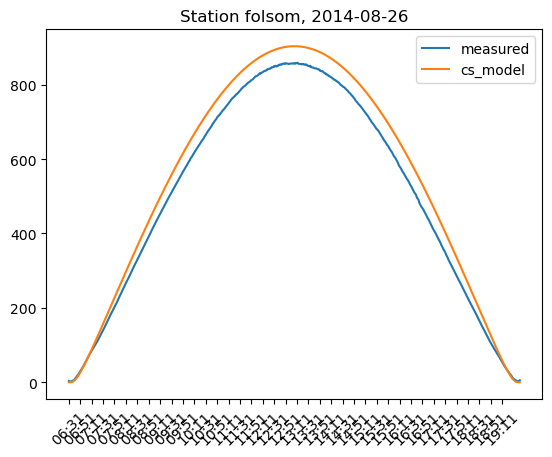

In [4]:
example_day = '2014-08-26'
example_train_df = get_example_df(df_folsom, example_day)
station = 'folsom'
date = example_train_df['datetime'].iloc[0].strftime('%Y-%m-%d')
plot_measurement_curve(example_train_df, station, date)

### Example 2: A day with clouds passing over the sensor

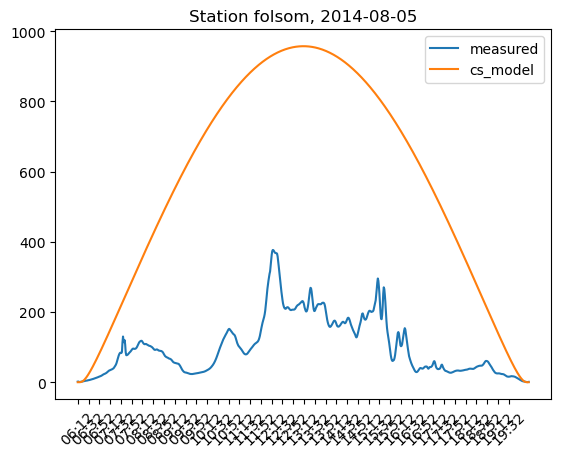

In [5]:
example_day2 = '2014-08-05'
example_train_df2 = get_example_df(df_folsom, example_day2)
station2 = 'folsom'
date2 = example_train_df2['datetime'].iloc[0].strftime('%Y-%m-%d')
plot_measurement_curve(example_train_df2, station2, date2)

# FFT Representation of the data

In [6]:
'''
Functions for FFT preprocessing
'''

def fft(nfft, window, signal):
    '''
    Extracts fft features for given time series.
    
    Parameters
    ----------
    nfft : int
        number of frequency bins
    window : np.array
        the window, resulting from window function, e.g., Hann
    signal : np.array
        the time series to be processed with fft
        
    Returns
    -------
    np.array
        an array with the (absolute and real) fft values
    '''
    if len(window) > len(signal):
        window = window[0:len(signal)]
    
    frame = signal * window
    fft = np.fft.rfft(frame, n=nfft)
    result = np.abs(fft)
    
    return result


def get_fft_matrices(input_signal, cs_signal, shift_size, window_size, window, nfft):
    '''
    Runs through a given measured and cs time series and applies a moving 
    window for which it calls the fft function.
    
    Parameters
    ----------
    input_signal : np.array
        a one-dimensional array containing measured, subsequent irradiance values
    cs_signal : np.array
        a one-dimensional array containing modelled, subsequent clear sky 
        irradiance values
    shift_size : int
        the number in minutes by which the moving window shall be shifted
    window_size : int
        the length of the window
    nfft : int
        the number of bins resulting from the fft to be applied
        
    Returns
    -------
    np.array
        a two-dimensional matrix with rows for fft applications and columns with 
        resulting fft values. Results from a measured irradiance signal.
    np.array
        a two-dimensional matrix with rows for fft applications and columns with 
        resulting fft values. Results from a clear sky irradiance signal.
    '''
    number_of_executions = math.ceil(len(input_signal) / shift_size)
    
    measured_matrix = np.zeros((number_of_executions, nfft // 2 + 1))
    cs_matrix = np.zeros((number_of_executions, nfft // 2 + 1))

    for idx in range(number_of_executions):
        signal_measured = input_signal[idx*shift_size:idx*shift_size+window_size]
        signal_cs = cs_signal[idx*shift_size:idx*shift_size+window_size]

        fft_measured = fft(nfft, window, signal_measured)
        fft_cs = fft(nfft, window, signal_cs)

        measured_matrix[idx, :] = fft_measured
        cs_matrix[idx, :] = fft_cs    
    
    return measured_matrix, cs_matrix


def get_frechet(input_signal, cs_signal, shift_size, window_size):
    '''
    Runs through a given measured and cs time series and applies a moving 
    window for which it calculates frechet distance.
    
    Parameters
    ----------
    input_signal : np.array
        a one-dimensional array containing measured, subsequent irradiance values
    cs_signal : np.array
        a one-dimensional array containing modelled, subsequent clear sky 
        irradiance values
    shift_size : int
        the number in minutes by which the moving window shall be shifted
    window_size : int
        the length of the window
        
    Returns
    -------
    np.array
        frechet dist.
    '''
    number_of_executions = math.ceil(len(input_signal) / shift_size)
    
    frechet_matrix = np.zeros(number_of_executions)

    for idx in range(number_of_executions):
        signal_measured = input_signal[idx*shift_size:idx*shift_size+window_size]
        signal_cs = cs_signal[idx*shift_size:idx*shift_size+window_size]
        idxs = list(range(len(signal_measured)))
        
        input_measured = list(zip(idxs, signal_measured))
        input_cs = list(zip(idxs, signal_cs))
        
        frechet = frdist(input_measured, input_cs)

        frechet_matrix[idx] = frechet
    
    return frechet_matrix


def get_correlation(input_signal, cs_signal, shift_size, window_size):
    '''
    Calculates person correlation for measured and clear-sky signal for a given window.
    
    Parameters
    ----------
    input_signal : np.array
        a one-dimensional array containing measured, subsequent irradiance values
    cs_signal : np.array
        a one-dimensional array containing modelled, subsequent clear sky 
        irradiance values
    shift_size : int
        the number in minutes by which the moving window shall be shifted
    window_size : int
        the length of the window
        
    Returns
    -------
    np.array
        pearson correlation coefficient
    '''
    number_of_executions = math.ceil(len(input_signal) / shift_size)
    
    correl_matrix = np.zeros(number_of_executions)

    for idx in range(number_of_executions):
        signal_measured = input_signal[idx*shift_size:idx*shift_size+window_size]
        signal_cs = cs_signal[idx*shift_size:idx*shift_size+window_size]
        
        try:
            correl = pearsonr(signal_measured, signal_cs)[0]
        except ValueError:
            #print('Lengths: measured: {}, cs: {}'.format(
            #        len(signal_measured), len(signal_cs)))
            correl = np.nan

        correl_matrix[idx] = correl
    
    return correl_matrix



def filter_df_on_time(df, y, m, d, h, minute, sec, diff_minutes):
    '''
    Filters a pd.DataFrame for given start datetime on subsequent time interval.
    
    Parameters
    ----------
    df : pd.DataFrame
        the dataframe to be filtered
    y, m, d, h, minute, sec : int
        the year, month, day, ... to define the datetime
    diff_minutes : int
        the length of the time interval to be filtered
        
    Returns
    -------
    pd.DataFrame
        the filtered dataframe
    '''
    start_dt = datetime.datetime(y, m, d, h, minute, sec)
    end_dt = start_dt + datetime.timedelta(minutes = diff_minutes)
    df = df[(df['datetime']>=start_dt) & 
            (df['datetime']<end_dt)]
    return df    

## Define FFT parameters

In [7]:
# sampling rate
f_sample = 1/60 # this is fixed since we have one measurement per minute

# Define the signal and window parameters
window_shape = 'hann' #boxcar, hann, hamming, triangle
window_size = 20 # we use 20-minute time series; more --> higher resolution, longer computing time
shift_size = 1

# Define the number of FFT points
nfft = 2 ** int(np.ceil(np.log2(window_size)))
print('nfft: {}'.format(nfft))

# Define the window function
window = get_window(window_shape, window_size)

# x_axis
frequencies = [n * f_sample / nfft for n in list(range(int(nfft / 2) + 1))]
freq_fft = np.fft.rfftfreq(nfft, 60)

nfft: 32


### FFT for Example 1, 12:00 to 12:20, clear sky

In [8]:
example_train_df = filter_df_on_time(example_train_df, 2014, 8, 26, 12, 0, 0, diff_minutes = window_size+1)

In [9]:
signal_measured_one = np.array(example_train_df['ghi'])
signal_cs_one = np.array(example_train_df['ghi_cs_haurwitz'])

measured_matrix, cs_matrix = get_fft_matrices(signal_measured_one, signal_cs_one, shift_size, window_size, window, nfft)
diff_matrix = measured_matrix - cs_matrix

example_train_df.reset_index(drop = True, inplace = True)
example_train_df = example_train_df[['date', 'time', 'ghi', 'ghi_cs_haurwitz']][0:window_size+1]

#### Normalize matrices for plot

In [10]:
def norm_matrices(measured_matrix, cs_matrix):
    measured_matrix_normed = measured_matrix / measured_matrix.max(axis = 0)
    cs_matrix_normed = cs_matrix / cs_matrix.max(axis = 0)
    return measured_matrix_normed, cs_matrix_normed

def fft_plots(df, measured_signal, cs_signal, measured_matrix, cs_matrix):
    # note: normalization only here for visualization, ML training is without normalizing
    measured_matrix_normed, cs_matrix_normed = norm_matrices(measured_matrix, cs_matrix)    

    number_of_executions = math.ceil(len(df) / shift_size) + 1 - window_size

    fig, axs = plt.subplots(nrows = number_of_executions, figsize = (10, 6*number_of_executions))
    axs[0].legend(['measured', 'cs_model'])

    for idx in range(number_of_executions):
        axs[idx].scatter(x = freq_fft, y=measured_matrix_normed[idx], label = 'measured')
        axs[idx].scatter(x = freq_fft, y=cs_matrix_normed[idx], label = 'cs_model')
        axs[idx].set_ylabel('FFT output in W/m² ')
        axs[idx].set_xlabel('Frequency in Hz')
        axs[idx].set_title('Time in min')
        axn = axs[idx].twiny().twinx()
        axn.plot(measured_signal[idx*shift_size:idx*shift_size+window_size]) # Create a dummy plot
        axn.plot(cs_signal[idx*shift_size:idx*shift_size+window_size])
        axn.set_ylabel('Irradiance in W/m²')        

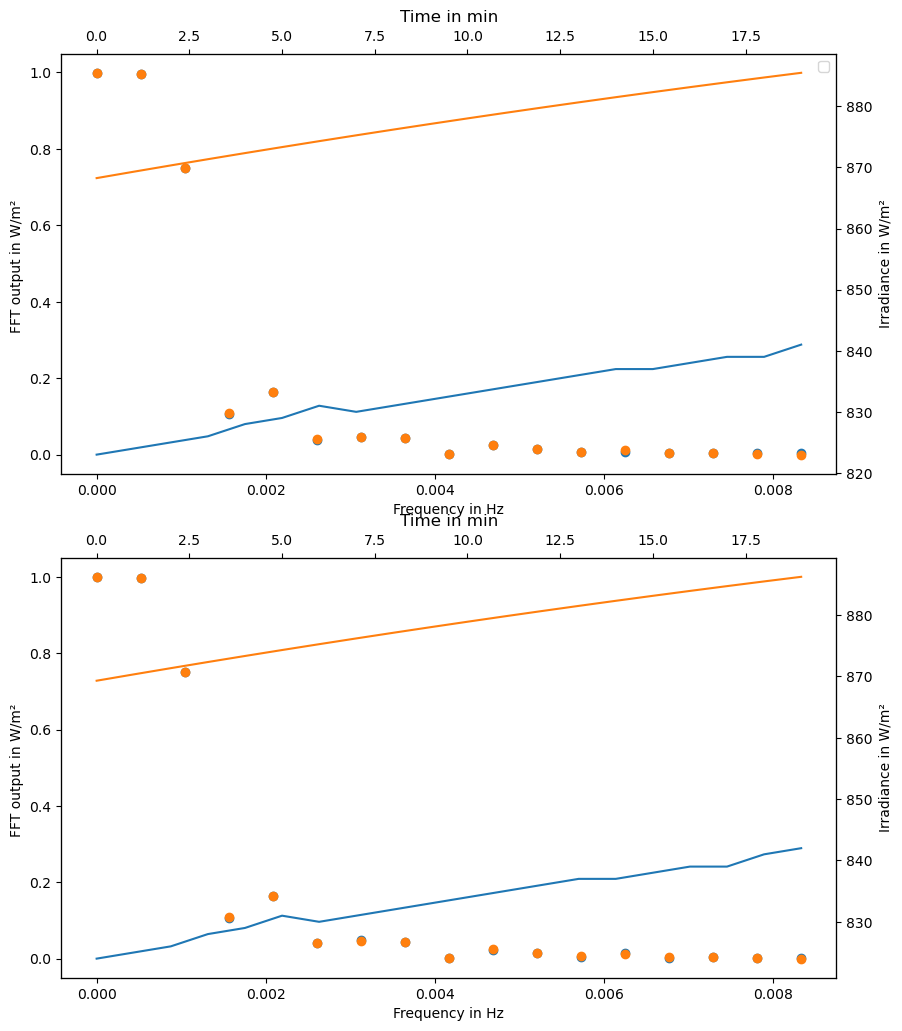

In [11]:
fft_plots(example_train_df, signal_measured_one, signal_cs_one, measured_matrix, cs_matrix)

#### Example 2, 12:00 to 12:20, clear sky

In [12]:
example_train_df2 = filter_df_on_time(example_train_df2, 2014, 8, 5, 14, 0, 0, diff_minutes = window_size+1)

In [13]:
signal_measured_two = np.array(example_train_df2['ghi'])
signal_cs_two = np.array(example_train_df2['ghi_cs_haurwitz'])
measured_matrix, cs_matrix = get_fft_matrices(signal_measured_two, signal_cs_two, shift_size, window_size, window, nfft)
example_train_df2.reset_index(drop = True, inplace = True)
example_train_df2 = example_train_df2[['date', 'time', 'ghi', 'ghi_cs_haurwitz']][0:window_size+1]

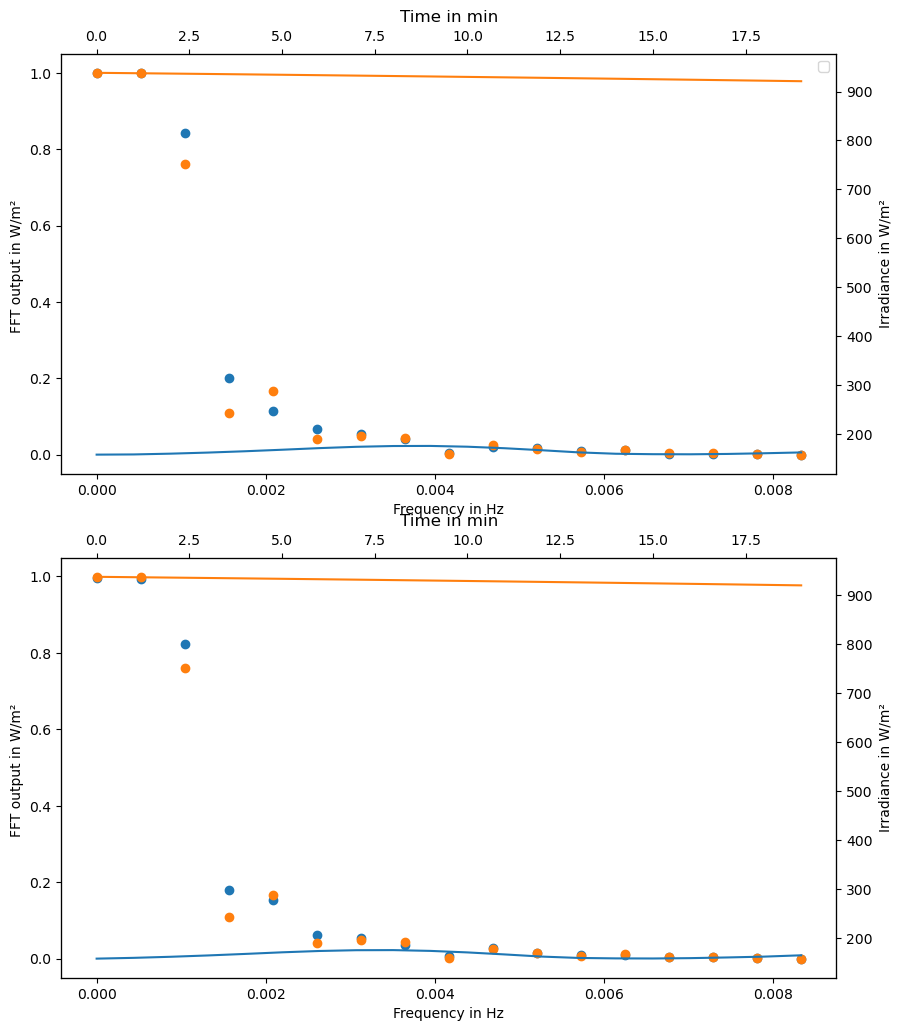

In [14]:
fft_plots(example_train_df2, signal_measured_two, signal_cs_two, measured_matrix, cs_matrix)

# Machine Learning Approach

## Feature extraction

### Functions for feature extraction

In [15]:
def get_labels(pre_labels, diff_matrix_len, window_size):
    # pre_labels are labels that were made manually for each minutely timestep but are shifted compared to fft
    '''
    Since we need windows for the fft operations, we have more than one minute (<window_size> minutes) 
    for each row in the train dataset. We thus assign the label of the minute in the middle of the
    window (int(window_size / 2)) to each row.
    ''' 
    labels = [1 if (pre_labels[idx+int(window_size/2)] == 1) else 0 
              for idx in range(diff_matrix_len-(window_size-int(window_size/2)))]
    return labels

def get_base_features(measured_matrix, cs_matrix):
    # difference between fft from measured data and fft from clear sky data
    diff_matrix = measured_matrix - cs_matrix

    # remove sign before feature set one
    diff_matrix_abs = np.abs(diff_matrix)

    # Feature set: relative difference between fft from measured data and fft from clear sky data
    rel_diff_matrix = diff_matrix_abs / cs_matrix
    
    return rel_diff_matrix    

def exclude_invalid_indices(df_ml_daily, invalid_indices, labels):
    df_ml_daily = df_ml_daily[:len(labels)]
    df_ml_daily['is_cs'] = labels
    invalid_indices = list(set(invalid_indices))
    df_ml_daily = df_ml_daily[~df_ml_daily.index.isin(df_ml_daily.iloc[invalid_indices].index)]
    df_ml_daily.reset_index(drop = True, inplace = True)
    return df_ml_daily

def get_deviation_matrix(shift, rel_diff_matrix, freq_fft):
    shift_matrix = np.roll(rel_diff_matrix, shift, axis = 0)
    deviation_shift_matrix = np.abs(shift_matrix - rel_diff_matrix)
    feature_columns = ['deviation_{}_freq_{}'.format(shift, f) for f in freq_fft]
    return deviation_shift_matrix, feature_columns        

In [16]:
def extract_features(daily_df):       
    signal_measured = np.array(daily_df['ghi'])
    signal_cs = np.array(daily_df['ghi_cs_haurwitz'])

    invalid_indices = [] # indices for minutes that cannot appropriately be predicted due to windowing
    columns = [] # column names for features

    # extract base features
    measured_matrix, cs_matrix = get_fft_matrices(signal_measured, signal_cs, shift_size, window_size, 
                                                  window, nfft)        
    rel_diff_matrix = get_base_features(measured_matrix, cs_matrix)

    # get frechet
    frechet = get_frechet(signal_measured, signal_cs, shift_size, window_size)
    columns.append('frechetdist')

    # get correlation
    correl = get_correlation(signal_measured, signal_cs, shift_size, window_size)
    columns.append('correlation')

    # The last valid label is a window length before the end of the dataset, since only then we have a full window following
    # Thus, we have to remove the window_size values from all data and feature sets
    invalid_indices += [(elem+1)*(-1) for elem in list(range(int(window_size/2)))] # those become invalid due to np.roll
    invalid_indices += [elem for elem in list(range(int(window_size/2)))]
    columns += ['rel_diff_freq_{}'.format(f) for f in freq_fft]
    
    # Feature: Deviation of window fft from window fft before
    rel_diff_matrix_before, columns_before = get_deviation_matrix(1, rel_diff_matrix, freq_fft)
    columns += columns_before
    invalid_indices += [max(invalid_indices) + 1]
    
    # Feature: Deviation of window fft from window fft before
    rel_diff_matrix_2before, columns_2before = get_deviation_matrix(2, rel_diff_matrix, freq_fft)
    columns += columns_2before
    invalid_indices += [max(invalid_indices) + 1]

    # Feature: Deviation of window fft from window fft before
    rel_diff_matrix_after, columns_after = get_deviation_matrix(-1, rel_diff_matrix, freq_fft)
    columns += columns_after 
    invalid_indices += [min(invalid_indices) - 1]
    
    # Feature: Deviation of window fft from window fft before
    rel_diff_matrix_2after, columns_2after = get_deviation_matrix(-2, rel_diff_matrix, freq_fft)
    columns += columns_2after
    invalid_indices += [min(invalid_indices) - 1]
    
    # get labels
    labels = get_labels(np.array(daily_df['is_cs_GT']), len(rel_diff_matrix), window_size)   

    # build daily ml df
    wide_array = np.hstack((rel_diff_matrix, frechet.reshape(len(frechet), 1), correl.reshape(len(correl), 1),
                           rel_diff_matrix_before, rel_diff_matrix_2before, rel_diff_matrix_after, rel_diff_matrix_2after))
    df_ml_daily = pd.DataFrame(data = wide_array, columns = columns)

    # keep original index             
    df_ml_daily['old_idx'] = daily_df.index + int(window_size/2) # we later want to map the mid-window minute with the label
    df_ml_daily = exclude_invalid_indices(df_ml_daily, invalid_indices, labels)
    return df_ml_daily

### Execute feature extraction

In [17]:
## ensure that no days are split
## still divide dataset into multiple datasets and apply feature extraction to split of dataset

df_folsom['year'] = pd.to_datetime(df_folsom['date']).apply(lambda x: x.year)

df_eval = df_folsom[df_folsom['year']>2014]
df_train = df_folsom[df_folsom['year']==2014]

def get_daily_dfs(df):
    days = df['date'].unique()
    daily_dfs = []
    for day in days:
        df_day = df[df['date'] == day] # here the dfs have ongoing indices
        daily_dfs.append(df_day)
    return daily_dfs

In [18]:
train_daily = get_daily_dfs(df_train)
eval_daily = get_daily_dfs(df_eval)

In [19]:
# hide warnings
warnings.filterwarnings('ignore')

def get_feature_df(tasklist):
    if os.name == 'nt': # check if windows system
        res = []
        for daily_df in tasklist:
            res.append(extract_features(daily_df))
        return res
    
    # only works on UNIX systems
    with Pool(cores_to_use) as pool:
        # feature extraction
        res = []

        # execute tasks in order
        for result in pool.map(extract_features, tasklist):
            res.append(result)
        return res
            
train_feature_df = get_feature_df(train_daily)

In [20]:
def get_whole_feature_df(res):
    df_ml = pd.concat(res, axis = 0).reset_index(drop = True)
    return df_ml

In [21]:
df_ml_train = get_whole_feature_df(train_feature_df)
df_ml_train.drop(columns = 'old_idx', inplace = True)

# same for evaluation data
eval_feature_df = get_feature_df(eval_daily)
df_ml_eval = get_whole_feature_df(eval_feature_df)

### Create df for machine learning

In [22]:
df_ml = copy.deepcopy(df_ml_train)
del df_ml_train
df_ml[['rel_diff_freq_0.0', 'is_cs']].groupby('is_cs').agg('count')
feature_columns = df_ml.columns[:-1]

In [23]:
df_ml[df_ml.columns[0:20]]

frechetdist  correlation  rel_diff_freq_0.0  \
0          0.164250     0.181362           0.250850   
1          0.170965     0.184170           0.232813   
2          0.174131     0.183054           0.211493   
3          0.174402     0.179319           0.191094   
4          0.172552     0.174187           0.174302   
...             ...          ...                ...   
243484     0.436583     0.453181           0.552298   
243485     0.505141     0.503560           0.542766   
243486     0.570452     0.544880           0.504113   
243487     0.636414     0.582931           0.447735   
243488     0.710367     0.626018           0.387333   

        rel_diff_freq_0.0005208333333333333  \
0                                  0.387498   
1                                  0.244496   
2                                  0.141555   
3                                  0.090851   
4                                  0.076517   
...                                     ...   
243484                             1.100328   
243485                             1.030797   
243486                             0.881262   
243487                             0.654799   
243488                             0.366377   

        rel_diff_freq_0.0010416666666666667  rel_diff_freq_0.0015625  \
0                                  0.214877                 1.408457   
1                                  0.127108                 0.925853   
2                                  0.279645                 0.154728   
3                                  0.272652                 0.359161   
4                                  0.198982                 0.105137   
...                                     ...                      ...   
243484                             1.334236                 0.721807   
243485                             2.031157                 1.016869   
243486                             2.601698                 1.694873   
243487                             2.826465                 2.455578   
243488                             2.565656                 2.891890   

        rel_diff_freq_0.0020833333333333333  \
0                                  0.083899   
1                                  0.500782   
2                                  0.385395   
3                                  0.667585   
4                                  0.530696   
...                                     ...   
243484                             3.545875   
243485                             3.101911   
243486                             2.160521   
243487                             1.846088   
243488                             2.533797   

        rel_diff_freq_0.0026041666666666665  rel_diff_freq_0.003125  \
0                                  1.736358                2.719693   
1                                  1.680834                0.473054   
2                                  0.585338                0.805557   
3                                  0.523002                1.519026   
4                                  0.031622                0.999805   
...                                     ...                     ...   
243484                             5.597444                7.296319   
243485                             5.236798                6.256420   
243486                             3.916593                5.018915   
243487                             1.892417                2.615823   
243488                             0.550382                0.218330   

        rel_diff_freq_0.0036458333333333334  \
0                                  1.294193   
1                                  2.019446   
2                                  1.292594   
3                                  0.146342   
4                                  0.371026   
...                                     ...   
243484                             9.095438   
243485                             7.859736   
243486                             7.693961   
243487                       

## Executing Machine Learning

### Separate Features and Labels

In [24]:
# check for nan values
n_nans = len(df_ml[df_ml.isnull().any(axis=1)])

if n_nans > 0:
    print('There are {} nan values. Filter them out')
else:
    print('No NaN values. You may proceed.')

No NaN values. You may proceed.


In [25]:
# shuffle df ml
df_ml_save = df_ml.copy()
df_ml = df_ml.sample(frac=1)

In [26]:
# under-sampling
min_count = min(df_ml_save[['is_cs', 'frechetdist']].groupby('is_cs').agg('count')['frechetdist'])
df_ml = df_ml_save.groupby('is_cs').sample(min_count)
df_ml = df_ml.sample(frac=1)
print('number of clear-sky samples: {}'.format(len(df_ml[df_ml['is_cs']==1])))
print('number of cloudy samples: {}'.format(len(df_ml[df_ml['is_cs']==0])))

number of clear-sky samples: 100598
number of cloudy samples: 100598


In [27]:
# Check for inf values and remove
df_ml.replace([np.inf, -np.inf], np.nan, inplace=True)

for col in df_ml.columns:
    if len(df_ml[df_ml[col].isnull()]) > 0:
        print('err in {}'.format(col))

In [28]:
X = df_ml[feature_columns]
y = df_ml['is_cs']

In [29]:
# if no feature selection:
X_selected = X
feature_columns_selected = X_selected.columns

## Gradient-boosted trees with cross-validation and selected features

In [30]:
# setting higher max_iter, e.g., to 200, may further increase performance
gbc = HistGradientBoostingClassifier(max_iter = 100, max_depth = 8,
                            min_samples_leaf = 20,
                            random_state = 999
                            )

k = 5
# we apply k-fold cross-validation
evaluation_metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
# since X instead of X_selected is used, all features are included
scores = cross_validate(gbc, X_selected, y, cv=k, scoring = evaluation_metrics) 
scores # scores shows us the accuracy achieved in each of the k folds

{'fit_time': array([5.25286722, 4.9893198 , 5.01362205, 5.07363153, 5.29040241]),
 'score_time': array([0.21666718, 0.16859722, 0.15958786, 0.16204524, 0.15839148]),
 'test_accuracy': array([0.94833499, 0.94848282, 0.94895499, 0.94796093, 0.95034668]),
 'test_precision': array([0.93162352, 0.93354795, 0.93369184, 0.93331731, 0.93629622]),
 'test_recall': array([0.96769384, 0.96570406, 0.96654903, 0.96486083, 0.96645129]),
 'test_f1': array([0.94931617, 0.94935379, 0.94983637, 0.94882698, 0.95113481]),
 'test_roc_auc': array([0.98748953, 0.98833861, 0.98818984, 0.9879076 , 0.98779805])}

# Evaluate

In [31]:
eval_clf = gbc
eval_clf.fit(X_selected, y) # fit classifier to all train/test data

HistGradientBoostingClassifier(max_depth=8, random_state=999)

In [32]:
def print_evaluation(df, gtcol, predcol):
    tp = len(df[(df[gtcol]==1) & (df[predcol]==1)])
    fn = len(df[(df[gtcol]==1) & (df[predcol]==0)])
    fp = len(df[(df[gtcol]==0) & (df[predcol]==1)])
    tn = len(df[(df[gtcol]==0) & (df[predcol]==0)])
          
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    fscore = 2*(precision*recall) / (precision + recall)
    print('Precision: {}'.format(precision))
    print('Recall: {}'.format(recall))
    print('Accuracy: {}'.format(accuracy))
    print('F1 score: {}'.format(fscore))

In [33]:
df_eval = df_ml_eval
print('Length of data for fitting is {}'.format(len(X_selected)))
print('Length of data for evaluation is {}'.format(len(df_eval)))

Length of data for fitting is 201196
Length of data for evaluation is 503033


In [34]:
X_eval = df_eval[feature_columns_selected]
y_eval = df_eval['is_cs']

pred_eval = eval_clf.predict(X_eval) # make predictions
evaluation_df = pd.DataFrame({'GT':y_eval, 'Predicted':pred_eval})

## Refinement for joining with original data - to have more information like, e.g., SZA
df_eval['pred_eval'] = pred_eval
df_eval['join_idx'] = df_eval['old_idx']

### Get final evaluation performance

In [35]:
# Read original data
df_evaluation = create_labeled_df(folsom_filename, label_filename)
df_evaluation['is_cs_GT'] = df_evaluation['manually_cs_labelled'].apply(lambda x: 1 if x == True else 0)
df_evaluation = pd.merge(df_evaluation, df_eval[['pred_eval', 'join_idx']], how = 'inner',
                        left_index = True, right_on = 'join_idx')
df_evaluation = df_evaluation[df_evaluation['apparent_zenith']<= 85] # filter on SZA <= 85°
print('Length of final evaluation data: {}'.format(len(df_evaluation)))

print_evaluation(df_evaluation, 'is_cs_GT', 'pred_eval')

Length of final evaluation data: 484469
Precision: 0.8563129413477638
Recall: 0.9570507222400018
Accuracy: 0.92254612782242
F1 score: 0.9038836891204451


### Get qualitative performance

In [36]:
def evaluation_plot(plot_df, col, lower_limit, upper_limit):
    plot_df = plot_df[plot_df.index.isin(range(lower_limit,upper_limit))]
    plot_df.index = pd.DatetimeIndex(plot_df['datetime'])
    plot_df.index = plot_df.index.to_series().apply(lambda x: x.strftime('%Y-%m-%d %H:%M'))

    fig, ax = plt.subplots(figsize = (14, 6))

    ax.plot(plot_df.index, plot_df['ghi'], label = 'Measured GHI', color = 'C0', linewidth=3)
    ax.plot(plot_df.index, plot_df['ghi_cs_haurwitz'], label = 'Clear-sky GHI', 
        color = '#ff7f0e', linestyle = 'dashed')
    ax.scatter(plot_df.index, plot_df[col], 
           color = 'black', label = 'is clear-sky', s = 60, alpha = 1)

    ax.set_ylim(20.0)
    ax.set_ylabel('Irradiance in W/m²')
    ax.legend()

    ax.xaxis.set_major_locator(plt.MaxNLocator(3))
    ax.set_xlabel('Datetime in Y-m-d H:M')

In [37]:
col = 'FFT-GBC_cs'
df_evaluation[col] = df_evaluation['pred_eval'] * df_evaluation['ghi']

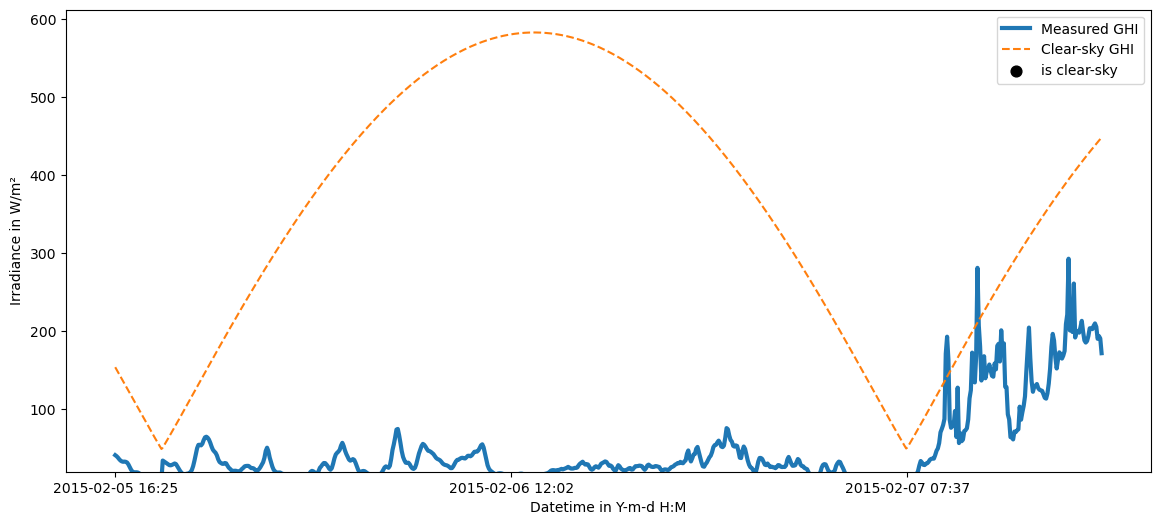

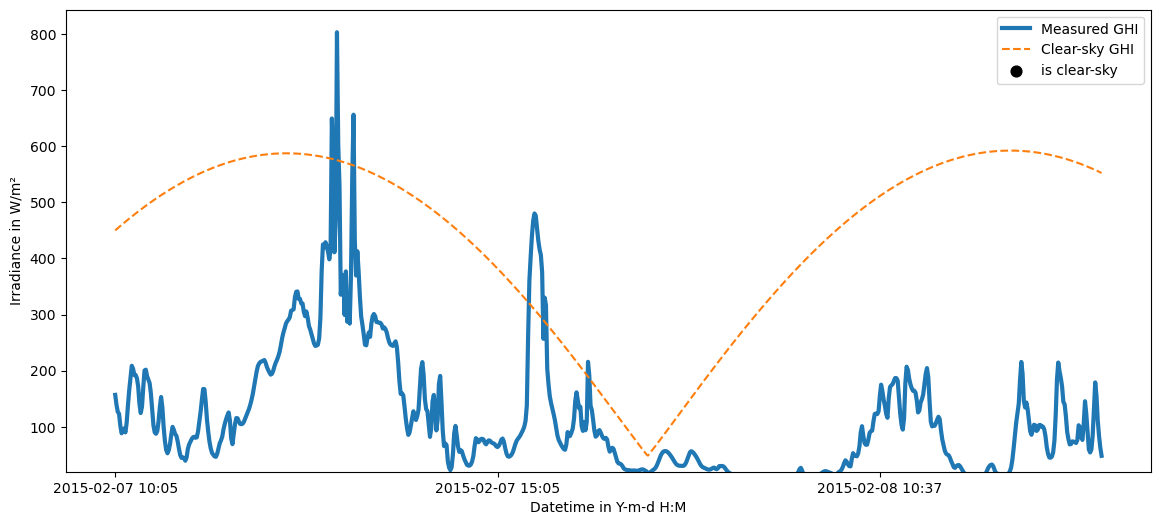

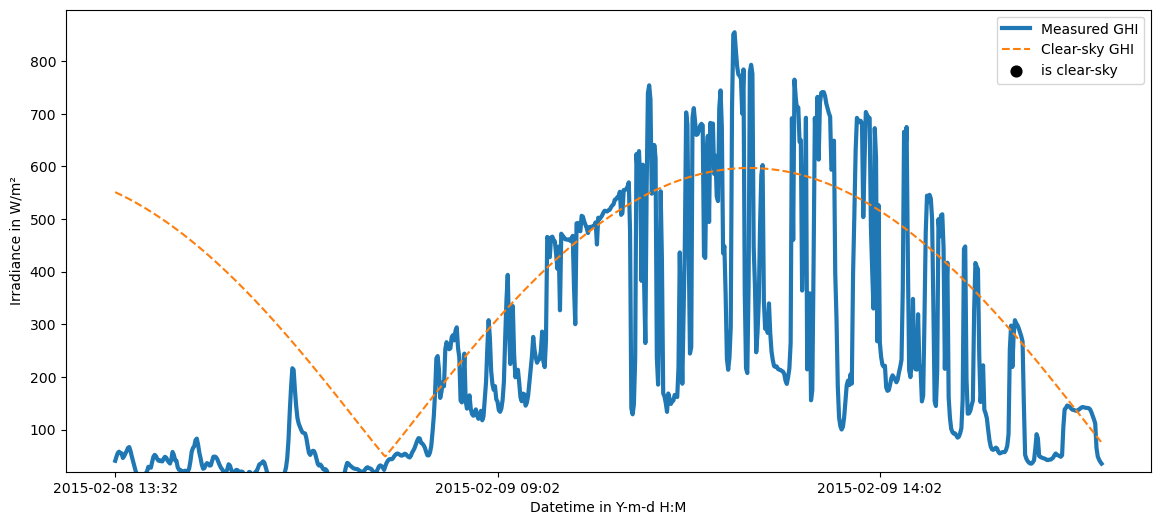

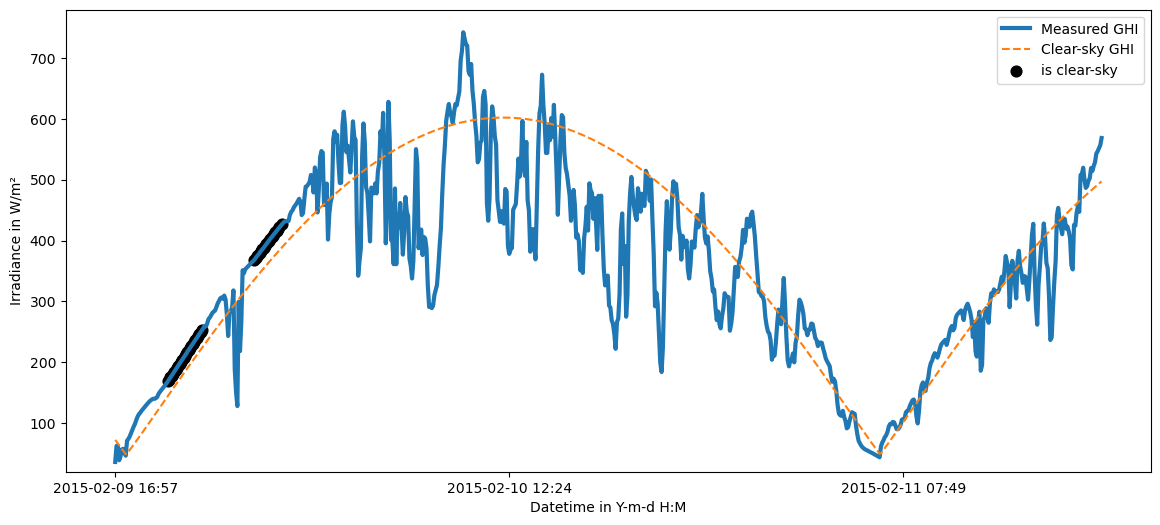

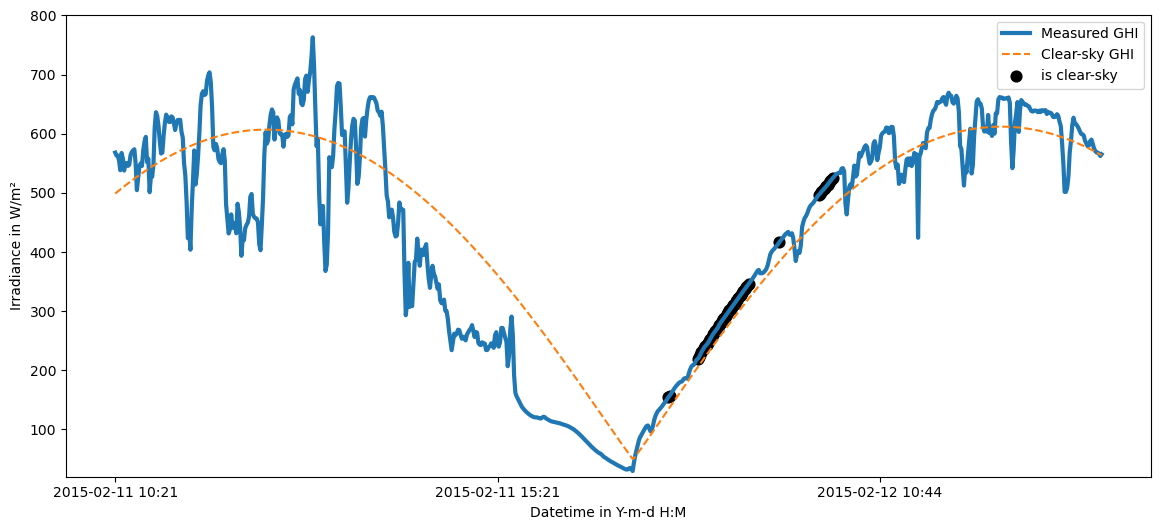

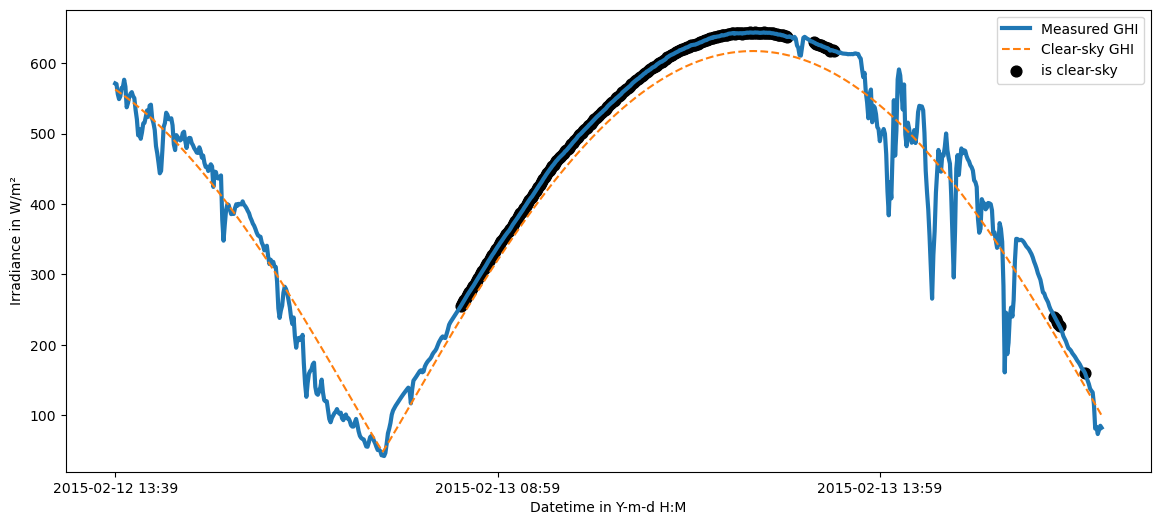

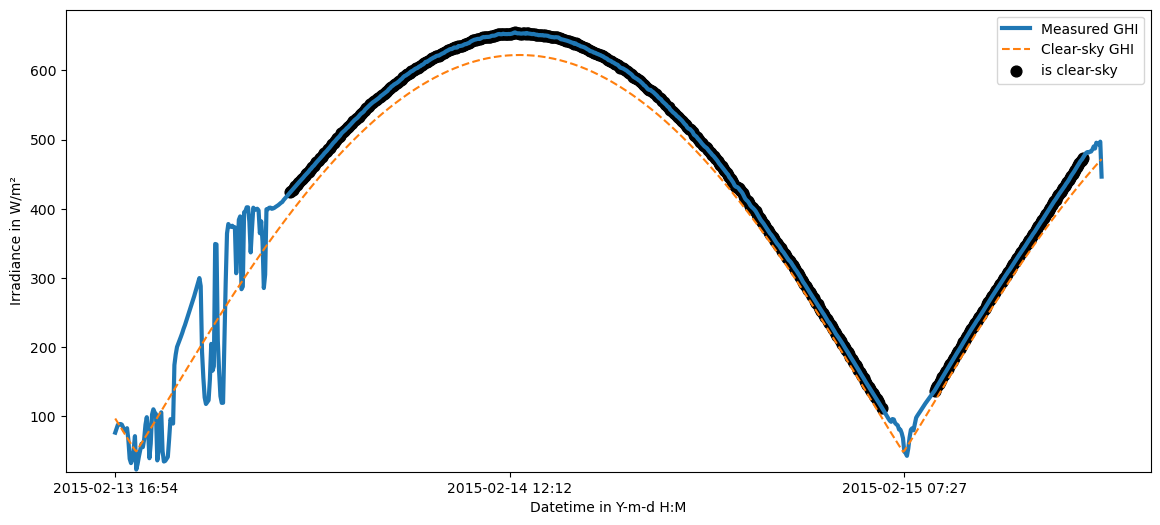

In [38]:
increment = 800
start = 20000
stop = 25000

while start < stop:
    end = start + increment
    evaluation_plot(df_evaluation, col, start, end)
    start = end

### Save model

In [39]:
datetimestring = datetime.datetime.now().strftime('%Y-%m-%d_%H%M%S')

model_name = 'data/gbc_model_{}_features_{}.pickle'.format(len(feature_columns_selected), datetimestring)
pickle.dump(eval_clf, open(model_name, 'wb'))